In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np

import sys
from pathlib import Path

# Add project paths
project_root = Path.cwd().parent

# Import experiment management from HDMF src folder
from fastHDMF.simulation_runner import HDMFSimulationRunner
from fastHDMF.experiment_manager import ExperimentManager


def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd




# Fitting grids

### Calculate fit with empirical data - HDMF

In [ ]:
exp = ExperimentManager(project_root=project_root, experiment_id="Fitting_Grid", results_dir="/network/iss/cohen/data/Ivan/fastHDMF/")
res = exp.load_experiment_results()
runner = HDMFSimulationRunner(experiment_manager=exp)
task = runner.tasks[0]
task['sc_matrix'] = runner.items[0][1]['sc_matrix']
params = runner.prepare_hdmf_params(task)

In [6]:
emp_fc = np.load(exp.data_dir / "COMA_CNT_Empirical_FC.npy")
emp_fcd = np.load(exp.data_dir / "COMA_CNT_Empirical_FCD.npy")

In [7]:
from scipy.stats import pearsonr
from scipy.stats import ks_2samp
from fastHDMF.utils import calculate_grid_size
from joblib import Parallel, delayed
triu_fc = np.triu_indices(res['full_results']['observables']['fc_bold'].shape[-1], 1)
triu_FCD    = np.triu_indices(res['full_results']['observables']['fcd_bold'].shape[-1], k=1)
grid_shape = (res['full_results']['observables']['fc_bold'].shape[0], res['full_results']['observables']['fc_bold'].shape[1])
results_FC = np.zeros(grid_shape)
results_FCD = np.zeros(grid_shape)
def compute_metrics(i, j, res, emp_fc, emp_fcd, triu_fc, triu_FCD):
    """Compute FC and FCD metrics for a single grid point."""
    sim_fc = np.squeeze(res['full_results']['observables']['fc_bold'][i, j, :, :])
    sim_fcd = np.squeeze(res['full_results']['observables']['fcd_bold'][i, j, :, :])

    # skip if any NaNs in the simulated FC or FCD
    if np.isnan(sim_fc).any() or np.isnan(sim_fcd).any():
        return np.nan, np.nan

    # compute FC correlation
    sim_fc = sim_fc - np.eye(sim_fc.shape[0])
    fc_corr = pearsonr(sim_fc[triu_fc], emp_fc[triu_fc])[0]

    # compute FCD KS distance
    sim_fcd_vals = sim_fcd[triu_FCD]
    fcd_ks = ks_2samp(sim_fcd_vals, emp_fcd)[0]
    
    return fc_corr, fcd_ks

# Parallelize over grid points
n_grid_i = res['full_results']['observables']['fc_bold'].shape[0]
n_grid_j = res['full_results']['observables']['fc_bold'].shape[1]

results = Parallel(n_jobs=32)(
    delayed(compute_metrics)(i, j, res, emp_fc, emp_fcd, triu_fc, triu_FCD)
    for i in range(n_grid_i)
    for j in range(n_grid_j)
)

# Reshape results back to grid
fc_results_flat, fcd_results_flat = zip(*results)
results_FC = np.array(fc_results_flat).reshape(grid_shape)
results_FCD = np.array(fcd_results_flat).reshape(grid_shape)

In [8]:
print(exp.experiment_dir / 'Observables_Grid')

/network/iss/cohen/data/Ivan/fastHDMF/AAL_HDMF_PAPER/Fitting_Grid/Observables_Grid


In [85]:
# Save the results
import scipy.io as sio
save_path = exp.experiment_dir / 'Observables_Grid'
save_path.mkdir(parents=True, exist_ok=True)
rates_grid_hdmf = res['full_results']['observables']['mean_rates']
sio.savemat(save_path / 'Fitting_Grid_Results.mat', {
    'results_FC': results_FC,
    'results_FCD': results_FCD,
    'rates_grid': rates_grid_hdmf,
    'g_values': res['full_results']['axis_values']['G'],
    'lr_values': res['full_results']['axis_values']['lrj']})

In [ ]:
# Save the results
import scipy.io as sio
save_path = exp.experiment_dir / 'Observables_Grid'
save_path.mkdir(parents=True, exist_ok=True)

sio.savemat(save_path / 'Fitting_Grid_Results.mat', {
    'results_FC': results_FC,
    'results_FCD': results_FCD,
    'rates_grid': rates_grid_dmf,
    'g_values': res['full_results']['axis_values']['G'],
    'alpha_values': res['full_results']['axis_values']['alpha']})

### Load calculated fit grid - HDMF

In [10]:
import scipy.io as sio
exp = ExperimentManager(project_root=project_root, experiment_id="Fitting_Grid", results_dir="/network/iss/cohen/data/Ivan/fastHDMF/")
# Load the results
save_path = exp.experiment_dir / 'Observables_Grid'
res_grid = sio.loadmat(save_path / 'Fitting_Grid_Results.mat')
HDMF_results_FC = res_grid['results_FC']
HDMF_results_FCD = res_grid['results_FCD']
#rates_grid_hdmf = res_grid['rates_grid']
g_values = res_grid['g_values'].flatten()
lr_values = res_grid['lr_values'].flatten()

In [11]:
# flip the y axis for plotting
HDMF_results_FC_flip = np.flipud(HDMF_results_FC)
HDMF_results_FCD_flip = np.flipud(HDMF_results_FCD)

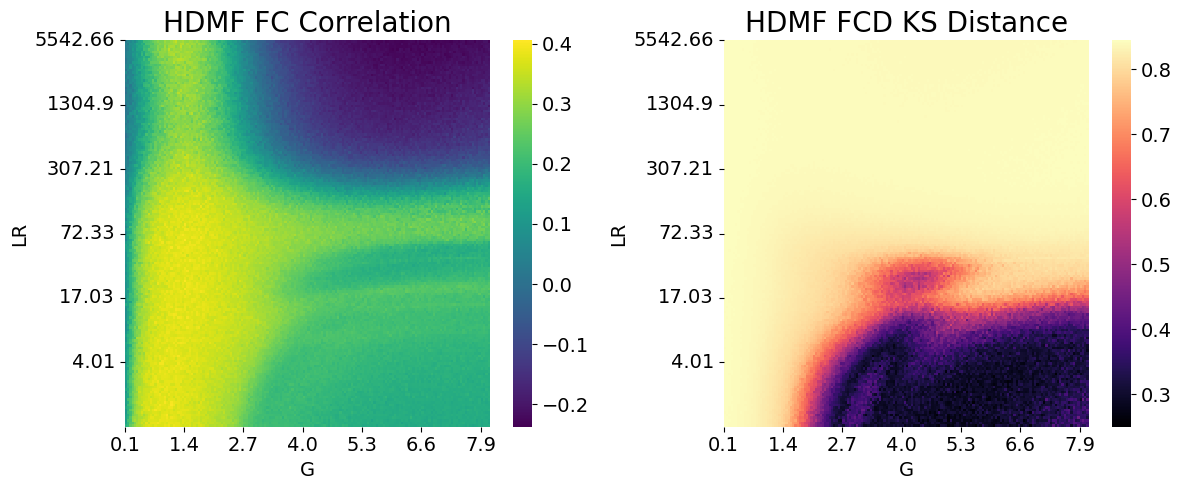

In [12]:
# Plot a heatmap of the results
import matplotlib.pyplot as plt
import seaborn as sns

TITLE = 20
TICKS = 14
LABEL= 14
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

LR_limit = 150
HDMF_results_FC_flip = HDMF_results_FC_flip[-LR_limit:, :]
HDMF_results_FCD_flip = HDMF_results_FCD_flip[-LR_limit:, :]

sns.heatmap(HDMF_results_FC_flip, annot=False, cmap="viridis")

#g_values = res['full_results']['axis_values']['G']
# Flip the lr values for correct orientation in the heatmap
#lr_values_flipped = res['full_results']['axis_values']['lrj'][::-1]
lr_values_flipped = lr_values[::-1]
lr_values_flipped = lr_values_flipped[-LR_limit:]
# Only plot every 10 labels to avoid clutter
plt.xticks(ticks=np.arange(0, len(g_values), max(1, len(g_values)//6)), labels=np.round(g_values[np.arange(0, len(g_values), max(1, len(g_values)//6))], 2),fontsize=TICKS,rotation=0)
plt.yticks(ticks=np.arange(0, len(lr_values_flipped), max(1, len(lr_values_flipped)//6)), labels=np.round(lr_values_flipped[np.arange(0, len(lr_values_flipped), max(1, len(lr_values_flipped)//6))], 2),fontsize=TICKS)
plt.title("HDMF FC Correlation", fontsize=TITLE)
plt.xlabel("G", fontsize=LABEL)
plt.ylabel("LR", fontsize=LABEL)
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=TICKS)
plt.subplot(1, 2, 2)
sns.heatmap(HDMF_results_FCD_flip, annot=False, cmap="magma")
plt.xticks(ticks=np.arange(0, len(g_values), max(1, len(g_values)//6)), labels=np.round(g_values[np.arange(0, len(g_values), max(1, len(g_values)//6))], 2),fontsize=TICKS,rotation=0)
plt.yticks(ticks=np.arange(0, len(lr_values_flipped), max(1, len(lr_values_flipped)//6)), labels=np.round(lr_values_flipped[np.arange(0, len(lr_values_flipped), max(1, len(lr_values_flipped)//6))], 2),fontsize=TICKS)
plt.title("HDMF FCD KS Distance", fontsize=TITLE)
plt.xlabel("G", fontsize=LABEL)
plt.ylabel("LR", fontsize=LABEL)
#Increase the size if the ticks labels in the colorbar
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=TICKS)

plt.tight_layout()
#plt.savefig("Fitting_Grid_Results_HDMF.png", dpi=300)
#plt.savefig("Fitting_Grid_Results_HDMF.svg", dpi=300)
plt.show()

### Load Fitting grid - DMF

In [13]:
exp = ExperimentManager(project_root=project_root, experiment_id="Fitting_Grid_Static", results_dir="/network/iss/cohen/data/Ivan/fastHDMF")
import scipy.io as sio
# Load the results
save_path = exp.experiment_dir / 'Observables_Grid'
res_grid = sio.loadmat(save_path / 'Fitting_Grid_Results.mat')
DMF_results_FC = res_grid['results_FC']
DMF_results_FCD = res_grid['results_FCD']
#rates_grid_dmf = res_grid['rates_grid']
g_values = res_grid['g_values'].flatten()
alpha_values = res_grid['alpha_values'].flatten()

In [14]:
# flip the y axis for plotting
DMF_results_FC_flip = np.flipud(DMF_results_FC)
DMF_results_FCD_flip = np.flipud(DMF_results_FCD)

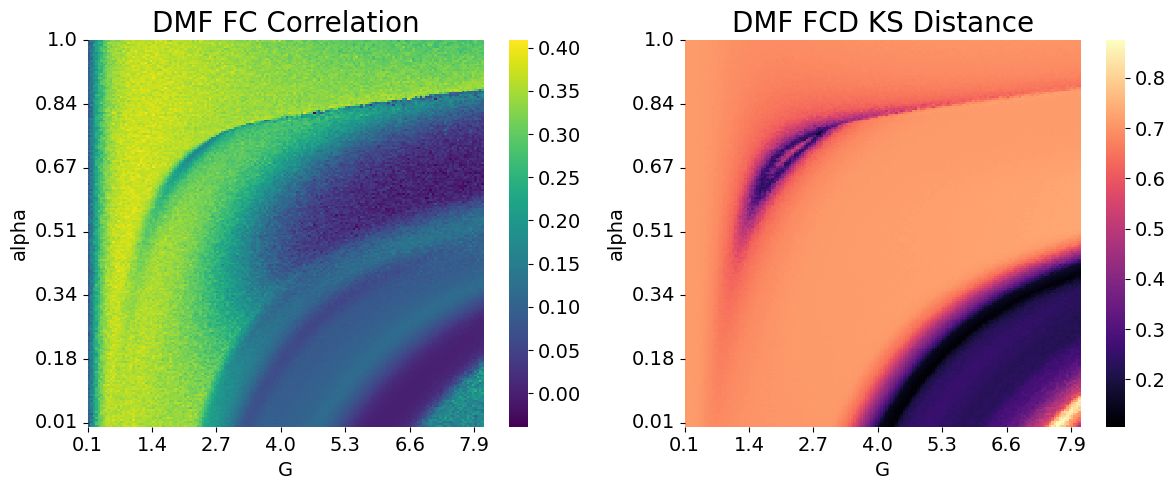

In [15]:
# Plot a heatmap of the results
import matplotlib.pyplot as plt
import seaborn as sns

TITLE = 20
TICKS = 14
LABEL = 14

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

sns.heatmap(DMF_results_FC_flip, annot=False, cmap="viridis")

#g_values = res['full_results']['axis_values']['G']
# Flip the alpha values for correct orientation in the heatmap
#alpha_values_flipped = res['full_results']['axis_values']['alphaj'][::-1]
alpha_values_flipped = alpha_values[::-1]
# Only plot every 10 labels to avoid clutter
plt.xticks(ticks=np.arange(0, len(g_values), max(1, len(g_values)//6)), labels=np.round(g_values[np.arange(0, len(g_values), max(1, len(g_values)//6))], 2), fontsize=TICKS, rotation=0)
plt.yticks(ticks=np.arange(0, len(alpha_values_flipped), max(1, len(alpha_values_flipped)//6)), labels=np.round(alpha_values_flipped[np.arange(0, len(alpha_values_flipped), max(1, len(alpha_values_flipped)//6))], 2), fontsize=TICKS)
plt.title("DMF FC Correlation", fontsize=TITLE)
plt.xlabel("G", fontsize=LABEL)
plt.ylabel("alpha", fontsize=LABEL)
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=TICKS)

plt.subplot(1, 2, 2)
sns.heatmap(DMF_results_FCD_flip, annot=False, cmap="magma")
plt.xticks(ticks=np.arange(0, len(g_values), max(1, len(g_values)//6)), labels=np.round(g_values[np.arange(0, len(g_values), max(1, len(g_values)//6))], 2), fontsize=TICKS, rotation=0)
plt.yticks(ticks=np.arange(0, len(alpha_values_flipped), max(1, len(alpha_values_flipped)//6)), labels=np.round(alpha_values_flipped[np.arange(0, len(alpha_values_flipped), max(1, len(alpha_values_flipped)//6))], 2), fontsize=TICKS)
plt.title("DMF FCD KS Distance", fontsize=TITLE)
plt.xlabel("G", fontsize=LABEL)
plt.ylabel("alpha", fontsize=LABEL)
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=TICKS)

plt.tight_layout()
#plt.savefig("Fitting_Grid_Results_DMF.png", dpi=300)
#plt.savefig("Fitting_Grid_Results_DMF.svg", dpi=300)
plt.show()

## Calcualte top 1% parameters with penalty

In [16]:
threshold_percent = 1  # percent of grid points to retain

def top_percent(values, percent, *, larger_is_better):
    values = np.asarray(values)
    flat = values.ravel()
    k = max(1, int(np.ceil(flat.size * percent / 100.0)))
    if larger_is_better:
        partition_idx = np.argpartition(flat, flat.size - k)[-k:]
        sorted_idx = partition_idx[np.argsort(flat[partition_idx])]
        sorted_idx = sorted_idx[::-1]
    else:
        partition_idx = np.argpartition(flat, k - 1)[:k]
        sorted_idx = partition_idx[np.argsort(flat[partition_idx])]
    unraveled = np.unravel_index(sorted_idx, values.shape)
    selected_values = flat[sorted_idx]
    threshold_value = float(selected_values[-1])
    return unraveled, selected_values, threshold_value

def gather_parameters(indices, *, g_axis, secondary_axis):
    row_idx, col_idx = indices
    g_vals = g_axis[col_idx]
    secondary_vals = secondary_axis[row_idx]
    return g_vals, secondary_vals

# HDMF metrics (higher FC, lower FCD)
adjusted_HDMF_best_FC_indices, adjusted_HDMF_best_FC, adjusted_HDMF_top_1_percent_FC = top_percent(
    HDMF_results_FC, 14, larger_is_better=True
)
adjusted_HDMF_best_FCD_indices, adjusted_HDMF_best_FCD, adjusted_HDMF_top_1_percent_FCD = top_percent(
    HDMF_results_FCD, 14, larger_is_better=False
)

# DMF metrics (higher FC, lower FCD)
adjusted_DMF_best_FC_indices, adjusted_DMF_best_FC, adjusted_DMF_top_1_percent_FC = top_percent(
    DMF_results_FC, 13, larger_is_better=True
)
adjusted_DMF_best_FCD_indices, adjusted_DMF_best_FCD, adjusted_DMF_top_1_percent_FCD = top_percent(
    DMF_results_FCD, 13, larger_is_better=False
)

In [17]:
# ...existing code...
threshold_percent = 1  # top 1%

# HDMF: thresholds (NaN-safe)
adjusted_HDMF_top_1_percent_FC  = np.nanpercentile(HDMF_results_FC, 100 - threshold_percent)
adjusted_HDMF_top_1_percent_FCD = np.nanpercentile(HDMF_results_FCD, threshold_percent)

# HDMF: indices
hdmf_fc_rows,  hdmf_fc_cols  = np.where(HDMF_results_FC  >= adjusted_HDMF_top_1_percent_FC)
hdmf_fcd_rows, hdmf_fcd_cols = np.where(HDMF_results_FCD <= adjusted_HDMF_top_1_percent_FCD)

# HDMF: parameter arrays for configs
top_g_values_HDMF_FC   = g_values[hdmf_fc_cols]
top_lr_values_HDMF_FC  = lr_values[hdmf_fc_rows]
top_g_values_HDMF_FCD  = g_values[hdmf_fcd_cols]
top_lr_values_HDMF_FCD = lr_values[hdmf_fcd_rows]

# DMF: thresholds (NaN-safe)
adjusted_DMF_top_1_percent_FC  = np.nanpercentile(DMF_results_FC, 100 - threshold_percent)
adjusted_DMF_top_1_percent_FCD = np.nanpercentile(DMF_results_FCD, threshold_percent)

# DMF: indices
dmf_fc_rows,  dmf_fc_cols  = np.where(DMF_results_FC  >= adjusted_DMF_top_1_percent_FC)
dmf_fcd_rows, dmf_fcd_cols = np.where(DMF_results_FCD <= adjusted_DMF_top_1_percent_FCD)
# DMF: parameter arrays for configs
top_g_values_DMF_FC    = g_values[dmf_fc_cols]
top_alpha_values_DMF_FC = alpha_values[dmf_fc_rows]
top_g_values_DMF_FCD   = g_values[dmf_fcd_cols]
top_alpha_values_DMF_FCD = alpha_values[dmf_fcd_rows]

print(f"HDMF FC top-1% points: {top_g_values_HDMF_FC.size}, FCD top-1%: {top_g_values_HDMF_FCD.size}")
print(f"DMF  FC top-1% points: {top_g_values_DMF_FC.size}, FCD top-1%: {top_g_values_DMF_FCD.size}")
# ...existing code...

HDMF FC top-1% points: 320, FCD top-1%: 320
DMF  FC top-1% points: 320, FCD top-1%: 320


In [81]:
import numpy as np

# Get top 38 points for HDMF FC (highest values) - handle NaNs properly
def get_top_n_points(values, n_points, larger_is_better=True):
    """Get the top n points from a 2D grid, handling NaN values."""
    # Flatten the array and get valid (non-NaN) indices
    values_flat = values.ravel()
    valid_mask = ~np.isnan(values_flat)
    valid_indices = np.where(valid_mask)[0]
    valid_values = values_flat[valid_indices]
    
    # Check if we have enough valid values
    if len(valid_values) < n_points:
        print(f"Warning: Only {len(valid_values)} valid values found, requested {n_points}")
        n_points = len(valid_values)
    
    if larger_is_better:
        # Get indices of top n values (highest)
        top_indices_in_valid = np.argpartition(valid_values, -n_points)[-n_points:]
        sorted_indices_in_valid = top_indices_in_valid[np.argsort(valid_values[top_indices_in_valid])[::-1]]
    else:
        # Get indices of top n values (lowest)
        top_indices_in_valid = np.argpartition(valid_values, n_points-1)[:n_points]
        sorted_indices_in_valid = top_indices_in_valid[np.argsort(valid_values[top_indices_in_valid])]
    
    # Map back to original flat indices
    sorted_indices = valid_indices[sorted_indices_in_valid]
    selected_values = values_flat[sorted_indices]
    
    # Convert flat indices back to 2D coordinates
    row_indices, col_indices = np.unravel_index(sorted_indices, values.shape)
    
    return row_indices, col_indices, selected_values

# Extract top 38 points for HDMF FC (highest correlations)
n_points = 38
hdmf_fc_top_rows, hdmf_fc_top_cols, hdmf_fc_top_values = get_top_n_points(
    adjusted_HDMF_FC, n_points, larger_is_better=True
)

# Extract top 38 points for HDMF FCD (lowest KS distances)  
hdmf_fcd_top_rows, hdmf_fcd_top_cols, hdmf_fcd_top_values = get_top_n_points(
    adjusted_HDMF_FCD, n_points, larger_is_better=False
)

# Get corresponding G and LR values for FC
top_38_g_values_HDMF_FC = g_values[hdmf_fc_top_cols]
top_38_lr_values_HDMF_FC = lr_values[hdmf_fc_top_rows]

# Get corresponding G and LR values for FCD
top_38_g_values_HDMF_FCD = g_values[hdmf_fcd_top_cols]  
top_38_lr_values_HDMF_FCD = lr_values[hdmf_fcd_top_rows]

print("Top 38 HDMF FC points:")
print("=" * 50)
print(f"FC scores: {hdmf_fc_top_values}")
print(f"G values: {top_38_g_values_HDMF_FC}")
print(f"LR values: {top_38_lr_values_HDMF_FC}")
print(f"Mean G: {np.mean(top_38_g_values_HDMF_FC):.4f}")
print(f"Mean LR: {np.mean(top_38_lr_values_HDMF_FC):.4f}")

print("\nTop 38 HDMF FCD points:")
print("=" * 50)
print(f"FCD scores: {hdmf_fcd_top_values}")
print(f"G values: {top_38_g_values_HDMF_FCD}")
print(f"LR values: {top_38_lr_values_HDMF_FCD}")
print(f"Mean G: {np.mean(top_38_g_values_HDMF_FCD):.4f}")
print(f"Mean LR: {np.mean(top_38_lr_values_HDMF_FCD):.4f}")

Top 38 HDMF FC points:
FC scores: [0.40576409 0.40283641 0.40166322 0.39968957 0.39967922 0.39936771
 0.39920712 0.39904403 0.39862454 0.39781392 0.39715425 0.39670542
 0.39640341 0.3961482  0.39576092 0.39561483 0.39537055 0.39532932
 0.39512353 0.39429399 0.39404807 0.39373612 0.39353084 0.39334917
 0.39327838 0.39326404 0.3932367  0.39319648 0.39299924 0.39292691
 0.39256956 0.39239666 0.39220202 0.39197241 0.39177766 0.39171524
 0.39165362 0.39164288]
G values: [1.4  1.1  1.4  1.25 1.1  1.1  0.95 1.   1.4  1.35 1.45 0.75 1.4  1.45
 1.5  0.9  1.75 1.25 0.85 1.15 1.   0.85 1.25 1.75 1.45 1.2  1.3  1.2
 0.8  1.1  0.95 1.2  1.1  1.   1.3  1.   1.7  0.9 ]
LR values: [64.42363509  1.58856513 25.52908068  4.7686117   1.68318035 54.15871378
  1.68318035  1.26038293 21.46141198 72.32633896 11.35733358  1.4149913
 91.158883   32.1764175  40.55460736  4.00880633 68.26071834 54.15871378
  4.00880633 12.03377841  5.35356668  1.58856513 11.35733358 20.25501939
  9.01101825 13.50993521  6.3682499

In [ ]:
import yaml
from pathlib import Path
import numpy as np

top_g_values, top_lr_values = top_38_g_values_HDMF_FC, top_38_lr_values_HDMF_FC


G_LRs = list(zip(top_g_values, top_lr_values))
tasks_list = [
    {'G': float(g_val), 'lrj': float(lr_val)}
    for g_val, lr_val in G_LRs
]

print(f"Generated {len(tasks_list)} tasks from HDMF top 1% FC fitting.")

config = {
    'experiment': {
        'description': f'Running {len(tasks_list)} parameter combinations from HDMF top 1% FC fitting',
        'version': '1.0'
    },
    'data': {
        'sc_root': 'Averaged_SCs/aal',
        'test_mode': False,
        'max_subjects_test': 1
    },
    'simulation': {
        'nb_steps': 192,
        'TR': 2.4,
        'obj_rate': 3.44,
        'with_decay': True,
        'with_plasticity': True,
        'flp': 0.01,
        'fhp': 0.1,
        'burnout': 8,
        'G': 1.0,
        'lr': 1.0,
        'over': {
            'seed': {
                'fun': 'np.arange',
                'args': [1, 101, 1]
            }
        },
        'parallel': True,
        'averaged': False
    },
    'tasks_list': tasks_list,
    'output': {
        'save_full_outputs': True,
        'observables': [
            {'name': 'fc', 'signal': 'bold'},
            {'name': 'fcd', 'signal': 'bold'},
            {'name': 'mean', 'signal': 'rates'}
        ]
    }
}

config_path = project_root / 'configs' / 'experiments' / 'Adjusted_HDMF_Top1%_FC_NoOverlap.yaml'
config_path.parent.mkdir(parents=True, exist_ok=True)

with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print(f"Config saved to: {config_path}")
print(f"Number of tasks: {len(tasks_list)}")
print("Sample tasks:")
for i, task in enumerate(tasks_list[:5]):
    print(f"  Task {i+1}: G={task['G']:.3f}, LR={task['lrj']:.3f}")
if len(tasks_list) > 5:
    print(f"  ... and {len(tasks_list)-5} more tasks")

Generated 38 tasks from HDMF top 1% FC fitting.
Config saved to: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Adjusted_HDMF_Top1%_FC_NoOverlap.yaml
Number of tasks: 38
Sample tasks:
  Task 1: G=1.400, LR=64.424
  Task 2: G=1.100, LR=1.589
  Task 3: G=1.400, LR=25.529
  Task 4: G=1.250, LR=4.769
  Task 5: G=1.100, LR=1.683
  ... and 33 more tasks


In [ ]:
import yaml
from pathlib import Path
import numpy as np

top_g_values, top_alpha_values = top_g_values_DMF_FC, top_alpha_values_DMF_FC



G_alphas = list(zip(top_g_values, top_alpha_values))
tasks_list = [
    {'G': float(g_val), 'alpha': float(alpha_val)}
    for g_val, alpha_val in G_alphas
]



print(f"Generated {len(tasks_list)} tasks from DMF top 1% FC fitting.")

config = {
    'experiment': {
        'description': f'Running {len(tasks_list)} parameter combinations from DMF top 1% FC fitting',
        'version': '1.0'
    },
    'data': {
        'sc_root': 'Averaged_SCs/aal',
        'test_mode': False,
        'max_subjects_test': 1
    },
    'simulation': {
        'nb_steps': 192,
        'TR': 2.4,
        'obj_rate': 3.44,
        'with_decay': False,
        'with_plasticity': False,
        'flp': 0.01,
        'fhp': 0.1,
        'burnout': 8,
        'G': 1.0,
        'alpha': 1.0,
        'over': {
            'seed': {
                'fun': 'np.arange',
                'args': [1, 101, 1]
            }
        },
        'parallel': True,
        'averaged': False
    },
    'tasks_list': tasks_list,
    'output': {
        'save_full_outputs': True,
        'observables': [
            {'name': 'fc', 'signal': 'bold'},
            {'name': 'fcd', 'signal': 'bold'},
            {'name': 'mean', 'signal': 'rates'}
        ]
    }
}

config_path = project_root / 'configs' / 'experiments' / 'Adjusted_DMF_Top1%_FC_NoOverlap.yaml'
config_path.parent.mkdir(parents=True, exist_ok=True)

with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print(f"Config saved to: {config_path}")
print(f"Number of tasks: {len(tasks_list)}")
print("Sample tasks:")
for i, task in enumerate(tasks_list[:5]):
    print(f"  Task {i+1}: G={task['G']:.3f}, alpha={task['alpha']:.3f}")
if len(tasks_list) > 5:
    print(f"  ... and {len(tasks_list)-5} more tasks")

Generated 38 tasks from DMF top 1% FC fitting.
Config saved to: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Adjusted_DMF_Top1%_FC_NoOverlap.yaml
Number of tasks: 38
Sample tasks:
  Task 1: G=0.600, alpha=0.483
  Task 2: G=0.700, alpha=0.537
  Task 3: G=0.850, alpha=0.547
  Task 4: G=0.900, alpha=0.547
  Task 5: G=0.900, alpha=0.577
  ... and 33 more tasks


In [ ]:
import yaml
from pathlib import Path
import numpy as np

top_g_values, top_lr_values = top_38_g_values_HDMF_FCD, top_38_lr_values_HDMF_FCD


G_LRs = list(zip(top_g_values, top_lr_values))
tasks_list = [
    {'G': float(g_val), 'lrj': float(lr_val)}
    for g_val, lr_val in G_LRs
]

print(f"Generated {len(tasks_list)} tasks from HDMF top 1% FCD fitting.")

config = {
    'experiment': {
        'description': f'Running {len(tasks_list)} parameter combinations from HDMF top 1% FCD fitting',
        'version': '1.0'
    },
    'data': {
        'sc_root': 'Averaged_SCs/aal',
        'test_mode': False,
        'max_subjects_test': 1
    },
    'simulation': {
        'nb_steps': 192,
        'TR': 2.4,
        'obj_rate': 3.44,
        'with_decay': True,
        'with_plasticity': True,
        'flp': 0.01,
        'fhp': 0.1,
        'burnout': 8,
        'G': 1.0,
        'lr': 1.0,
        'over': {
            'seed': {
                'fun': 'np.arange',
                'args': [1, 101, 1]
            }
        },
        'parallel': True,
        'averaged': False
    },
    'tasks_list': tasks_list,
    'output': {
        'save_full_outputs': True,
        'observables': [
            {'name': 'fc', 'signal': 'bold'},
            {'name': 'fcd', 'signal': 'bold'},
            {'name': 'mean', 'signal': 'rates'}
        ]
    }
}

config_path = project_root / 'configs' / 'experiments' / 'Adjusted_HDMF_Top1%_FCD_NoOverlap.yaml'
config_path.parent.mkdir(parents=True, exist_ok=True)

with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print(f"Config saved to: {config_path}")
print(f"Number of tasks: {len(tasks_list)}")
print("Sample tasks:")
for i, task in enumerate(tasks_list[:5]):
    print(f"  Task {i+1}: G={task['G']:.3f}, LR={task['lrj']:.3f}")
if len(tasks_list) > 5:
    print(f"  ... and {len(tasks_list)-5} more tasks")

Generated 38 tasks from HDMF top 1% FCD fitting.
Config saved to: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Adjusted_HDMF_Top1%_FCD_NoOverlap.yaml
Number of tasks: 38
Sample tasks:
  Task 1: G=7.350, LR=3.181
  Task 2: G=5.200, LR=2.121
  Task 3: G=5.550, LR=1.683
  Task 4: G=4.800, LR=1.415
  Task 5: G=5.600, LR=1.000
  ... and 33 more tasks


In [ ]:
import yaml
from pathlib import Path
import numpy as np

top_g_values, top_alpha_values = top_g_values_DMF_FCD, top_alpha_values_DMF_FCD

print("Top 1% DMF FCD scores:", adjusted_DMF_best_FCD)
print("Top 1% DMF FCD G values:", top_g_values)
print("Top 1% DMF FCD alpha values:", top_alpha_values)
print(f"Threshold (<=): {adjusted_DMF_top_1_percent_FCD:.4f}")
print("Mean G value:", np.mean(top_g_values))
print("Mean alpha value:", np.mean(top_alpha_values))
print("Median G value:", np.median(top_g_values))
print("Median alpha value:", np.median(top_alpha_values))

G_alphas = list(zip(top_g_values, top_alpha_values))
tasks_list = [
    {'G': float(g_val), 'alpha': float(alpha_val)}
    for g_val, alpha_val in G_alphas
]

print(f"Generated {len(tasks_list)} tasks from DMF top 1% FCD fitting.")

config = {
    'experiment': {
        'description': f'Running {len(tasks_list)} parameter combinations from DMF top 1% FCD fitting',
        'version': '1.0'
    },
    'data': {
        'sc_root': 'Averaged_SCs/aal',
        'test_mode': False,
        'max_subjects_test': 1
    },
    'simulation': {
        'nb_steps': 192,
        'TR': 2.4,
        'obj_rate': 3.44,
        'with_decay': False,
        'with_plasticity': False,
        'flp': 0.01,
        'fhp': 0.1,
        'burnout': 8,
        'G': 1.0,
        'alpha': 1.0,
        'over': {
            'seed': {
                'fun': 'np.arange',
                'args': [1, 101, 1]
            }
        },
        'parallel': True,
        'averaged': False
    },
    'tasks_list': tasks_list,
    'output': {
        'save_full_outputs': True,
        'observables': [
            {'name': 'fc', 'signal': 'bold'},
            {'name': 'fcd', 'signal': 'bold'},
            {'name': 'mean', 'signal': 'rates'}
        ]
    }
}

config_path = project_root / 'configs' / 'experiments' / 'Adjusted_DMF_Top1%_FCD_NoOverlap.yaml'
config_path.parent.mkdir(parents=True, exist_ok=True)

with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print(f"Config saved to: {config_path}")
print(f"Number of tasks: {len(tasks_list)}")
print("Sample tasks:")
for i, task in enumerate(tasks_list[:5]):
    print(f"  Task {i+1}: G={task['G']:.3f}, alpha={task['alpha']:.3f}")
if len(tasks_list) > 5:
    print(f"  ... and {len(tasks_list)-5} more tasks")

Top 1% DMF FCD scores: [0.26415794 0.26270032 0.26590858 0.22068739 0.27651432 0.24994266
 0.22862017 0.23124296 0.26995941 0.2814383  0.23634992 0.26123578
 0.26514666 0.24342021 0.26105733 0.27033398 0.2507115  0.24627934
 0.27487304 0.22823094 0.21937098 0.24709142 0.25640263 0.23110217
 0.23302235 0.26833318 0.25355761 0.24644986 0.26212956 0.24253474
 0.22489257 0.25256326 0.18033289 0.28206068 0.23152825 0.2766675
 0.27510548 0.26350429]
Top 1% DMF FCD G values: [1.85 1.85 1.9  1.95 1.9  1.95 2.   2.05 2.05 2.1  2.15 2.15 2.2  2.25
 2.3  2.25 2.3  2.35 2.4  2.45 2.5  2.4  2.45 2.5  2.55 2.5  2.55 2.6
 2.6  2.65 2.7  2.75 2.8  2.8  2.85 2.8  2.9  2.95]
Top 1% DMF FCD alpha values: [0.69653266 0.70150754 0.70150754 0.70150754 0.70648241 0.70648241
 0.70648241 0.71643216 0.72140704 0.72140704 0.72638191 0.73135678
 0.73135678 0.73633166 0.73633166 0.74130653 0.74130653 0.74130653
 0.74628141 0.74628141 0.74628141 0.75125628 0.75125628 0.75125628
 0.75125628 0.75623116 0.75623116 0.7

# Overlap analysis

## HDMF

In [18]:
# Overlap analysis for HDMF across all thresholds (1-100%)
# Store results for each threshold
hdmf_overlap_results = {}
total_valid = np.count_nonzero(~np.isnan(HDMF_results_FC))

print("Overlap analysis for HDMF across all percentiles (1-100%):")
print("=" * 60)

for thresh in range(1, 101):
    # For FC: higher correlation is better (ignore NaNs)
    fc_threshold = np.nanpercentile(HDMF_results_FC, 100 - thresh)
    fc_mask = HDMF_results_FC >= fc_threshold

    # For FCD: lower KS distance is better (ignore NaNs)
    fcd_threshold = np.nanpercentile(HDMF_results_FCD, thresh)
    fcd_mask = HDMF_results_FCD <= fcd_threshold

    # Find overlap
    overlap = fc_mask & fcd_mask
    n_overlap = np.sum(overlap)

    # Get maximum FC and minimum FCD in the overlap region
    if n_overlap > 0:
        max_fc_in_overlap = np.max(HDMF_results_FC[overlap])
        min_fcd_in_overlap = np.min(HDMF_results_FCD[overlap])
    else:
        max_fc_in_overlap = None
        min_fcd_in_overlap = None
    

    # Store results
    hdmf_overlap_results[thresh] = {
        'n_overlap': n_overlap,
        'overlap_percent': 100 * n_overlap / total_valid,
        'fc_threshold': fc_threshold,
        'fcd_threshold': fcd_threshold,
        'max_fc_in_overlap': max_fc_in_overlap,
        'min_fcd_in_overlap': min_fcd_in_overlap,
        'fc_mask': fc_mask,
        'fcd_mask': fcd_mask,
        'overlap_mask': overlap
    }
    
    if thresh % 10 == 0:
        print(f"Top {thresh}%: {n_overlap} overlap points ({100 * n_overlap / total_valid:.2f}% of valid grid)")

print("\nOverlap analysis complete. Data stored in hdmf_overlap_results.")


Overlap analysis for HDMF across all percentiles (1-100%):
Top 10%: 0 overlap points (0.00% of valid grid)
Top 20%: 753 overlap points (2.35% of valid grid)
Top 30%: 3318 overlap points (10.37% of valid grid)
Top 40%: 8367 overlap points (26.15% of valid grid)
Top 50%: 11294 overlap points (35.29% of valid grid)
Top 60%: 13684 overlap points (42.76% of valid grid)
Top 70%: 15246 overlap points (47.64% of valid grid)
Top 80%: 19386 overlap points (60.58% of valid grid)
Top 90%: 25600 overlap points (80.00% of valid grid)
Top 100%: 32000 overlap points (100.00% of valid grid)

Overlap analysis complete. Data stored in hdmf_overlap_results.


In [ ]:
import yaml
from pathlib import Path
import numpy as np
threshold_percent = 14
# Get overlap mask for top 1% threshold
overlap_mask = hdmf_overlap_results[threshold_percent]['overlap_mask']

# Get the indices where overlap occurs
overlap_rows, overlap_cols = np.where(overlap_mask)

# Get corresponding G and LR values
top_g_values = g_values[overlap_cols]
top_lr_values = lr_values[overlap_rows]

G_LRs = list(zip(top_g_values, top_lr_values))
tasks_list = [
    {'G': float(g_val), 'lrj': float(lr_val)}
    for g_val, lr_val in G_LRs
]

print(f"Generated {len(tasks_list)} tasks from HDMF top 1% FC fitting.")

config = {
    'experiment': {
        'description': f'Running {len(tasks_list)} parameter combinations from HDMF top 1% FC fitting',
        'version': '1.0'
    },
    'data': {
        'sc_root': 'Averaged_SCs/aal',
        'test_mode': False,
        'max_subjects_test': 1
    },
    'simulation': {
        'nb_steps': 192,
        'TR': 2.4,
        'obj_rate': 3.44,
        'with_decay': True,
        'with_plasticity': True,
        'flp': 0.01,
        'fhp': 0.1,
        'burnout': 8,
        'G': 1.0,
        'lr': 1.0,
        'over': {
            'seed': {
                'fun': 'np.arange',
                'args': [1, 101, 1]
            }
        },
        'parallel': True,
        'averaged': False
    },
    'tasks_list': tasks_list,
    'output': {
        'results_dir': f'AAL_HDMF_PAPER',
        'save_full_outputs': True,
        'observables': [
            {'name': 'fc', 'signal': 'bold'},
            {'name': 'fcd', 'signal': 'bold'},
            {'name': 'mean', 'signal': 'rates'}
        ]
    }
}

config_path = project_root / 'configs' / 'experiments' / f'HDMF_TOP{threshold_percent}%_Overlap.yaml'
config_path.parent.mkdir(parents=True, exist_ok=True)

#with open(config_path, 'w') as f:
#    yaml.dump(config, f, default_flow_style=False)

print(f"Config saved to: {config_path}")
print(f"Number of tasks: {len(tasks_list)}")
print("Sample tasks:")
for i, task in enumerate(tasks_list[:5]):
    print(f"  Task {i+1}: G={task['G']:.3f}, LR={task['lrj']:.3f}")
if len(tasks_list) > 5:
    print(f"  ... and {len(tasks_list)-5} more tasks")

Generated 21 tasks from HDMF top 1% FC fitting.
Config saved to: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Adjusted_HDMF_Top1%_FC_NoOverlap.yaml
Number of tasks: 21
Sample tasks:
  Task 1: G=2.150, LR=1.000
  Task 2: G=2.200, LR=1.000
  Task 3: G=2.300, LR=1.000
  Task 4: G=2.150, LR=1.060
  Task 5: G=2.250, LR=1.060
  ... and 16 more tasks


In [23]:
# Overlap analysis for DMF across all thresholds (1-100%)
# Store results for each threshold
dmf_overlap_results = {}
total_valid_dmf = len(DMF_results_FC.flatten())

print("Overlap analysis for DMF across all percentiles (1-100%):")
print("=" * 60)

for thresh in range(1, 101):
    # For FC: higher correlation is better
    fc_threshold = np.percentile(DMF_results_FC, 100 - thresh)
    fc_mask = DMF_results_FC >= fc_threshold
    
    # For FCD: lower KS distance is better
    fcd_threshold = np.percentile(DMF_results_FCD, thresh)
    fcd_mask = DMF_results_FCD <= fcd_threshold
    
    # Find overlap
    overlap = fc_mask & fcd_mask
    n_overlap = np.sum(overlap)

    # Get maximum FC and minimum FCD in the overlap region
    if n_overlap > 0:
        max_fc_in_overlap = np.max(DMF_results_FC[overlap])
        min_fcd_in_overlap = np.min(DMF_results_FCD[overlap])
    else:
        max_fc_in_overlap = None
        min_fcd_in_overlap = None
    
    # Store results
    dmf_overlap_results[thresh] = {
        'n_overlap': n_overlap,
        'overlap_percent': 100 * n_overlap / total_valid_dmf,
        'fc_threshold': fc_threshold,
        'fcd_threshold': fcd_threshold,
        'max_fc_in_overlap': max_fc_in_overlap,
        'min_fcd_in_overlap': min_fcd_in_overlap,
        'fc_mask': fc_mask,
        'fcd_mask': fcd_mask,
        'overlap_mask': overlap
    }
    
    if thresh % 10 == 0:
        print(f"Top {thresh}%: {n_overlap} overlap points ({100 * n_overlap / total_valid_dmf:.2f}% of total grid)")

print("\nOverlap analysis complete. Data stored in dmf_overlap_results.")


Overlap analysis for DMF across all percentiles (1-100%):
Top 10%: 2 overlap points (0.01% of total grid)
Top 20%: 397 overlap points (1.24% of total grid)
Top 30%: 2731 overlap points (8.53% of total grid)
Top 40%: 6079 overlap points (19.00% of total grid)
Top 50%: 9546 overlap points (29.83% of total grid)
Top 60%: 12895 overlap points (40.30% of total grid)
Top 70%: 17454 overlap points (54.54% of total grid)
Top 80%: 22665 overlap points (70.83% of total grid)
Top 90%: 26987 overlap points (84.33% of total grid)
Top 100%: 32000 overlap points (100.00% of total grid)

Overlap analysis complete. Data stored in dmf_overlap_results.


In [24]:
import yaml
from pathlib import Path
import numpy as np
threshold_percent = 13
# Get overlap mask for top 1% threshold
overlap_mask = dmf_overlap_results[threshold_percent]['overlap_mask']

# Get the indices where overlap occurs
overlap_rows, overlap_cols = np.where(overlap_mask)

# Get corresponding G and alpha values
top_g_values = g_values[overlap_cols]
top_alpha_values = alpha_values[overlap_rows]

G_alphas = list(zip(top_g_values, top_alpha_values))
tasks_list = [
    {'G': float(g_val), 'alpha': float(alpha_val)}
    for g_val, alpha_val in G_alphas
]

print(f"Generated {len(tasks_list)} tasks from HDMF top 1% FC fitting.")

config = {
    'experiment': {
        'description': f'Running {len(tasks_list)} parameter combinations from HDMF top 1% FC fitting',
        'version': '1.0'
    },
    'data': {
        'sc_root': 'Averaged_SCs/aal',
        'test_mode': False,
        'max_subjects_test': 1
    },
    'simulation': {
        'nb_steps': 192,
        'TR': 2.4,
        'obj_rate': 3.44,
        'with_decay': False,
        'with_plasticity': False,
        'flp': 0.01,
        'fhp': 0.1,
        'burnout': 8,
        'G': 1.0,
        'alpha': 1.0,
        'over': {
            'seed': {
                'fun': 'np.arange',
                'args': [1, 101, 1]
            }
        },
        'parallel': True,
        'averaged': False
    },
    'tasks_list': tasks_list,
    'output': {
        'results_dir': f'AAL_HDMF_PAPER',
        'save_full_outputs': True,
        'observables': [
            {'name': 'fc', 'signal': 'bold'},
            {'name': 'fcd', 'signal': 'bold'},
            {'name': 'mean', 'signal': 'rates'}
        ]
    }
}

config_path = project_root / 'configs' / 'experiments' / f'DMF_TOP{threshold_percent}%_Overlap.yaml'
config_path.parent.mkdir(parents=True, exist_ok=True)

#with open(config_path, 'w') as f:
#    yaml.dump(config, f, default_flow_style=False)

print(f"Config saved to: {config_path}")
print(f"Number of tasks: {len(tasks_list)}")
print("Sample tasks:")
for i, task in enumerate(tasks_list[:5]):
    print(f"  Task {i+1}: G={task['G']:.3f}, alpha={task['alpha']:.3f}")
if len(tasks_list) > 5:
    print(f"  ... and {len(tasks_list)-5} more tasks")

Generated 20 tasks from HDMF top 1% FC fitting.
Config saved to: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/DMF_TOP13%_Overlap.yaml
Number of tasks: 20
Sample tasks:
  Task 1: G=1.650, alpha=0.667
  Task 2: G=1.700, alpha=0.672
  Task 3: G=1.850, alpha=0.702
  Task 4: G=1.900, alpha=0.702
  Task 5: G=1.950, alpha=0.702
  ... and 15 more tasks


In [13]:
# Save the results
import scipy.io as sio
import pickle

exp = ExperimentManager(project_root=project_root, experiment_id="Fitting_Grid", results_dir="/network/iss/cohen/data/Ivan/fastHDMF/")
save_path = exp.experiment_dir / 'Observables_Grid'
save_path.mkdir(parents=True, exist_ok=True)

# Save as pickle instead of .mat (preserves dict structure)
with open(save_path / 'Overlap_Results.pkl', 'wb') as f:
    pickle.dump(hdmf_overlap_results, f)

exp = ExperimentManager(project_root=project_root, experiment_id="Fitting_Grid_Static", results_dir="/network/iss/cohen/data/Ivan/fastHDMF/")
save_path = exp.experiment_dir / 'Observables_Grid'
save_path.mkdir(parents=True, exist_ok=True)

with open(save_path / 'Overlap_Results.pkl', 'wb') as f:
    pickle.dump(dmf_overlap_results, f)

2025-12-15 19:26:53,202 - hdmf_experiment_Fitting_Grid - INFO - Experiment 'Fitting_Grid' initialized
2025-12-15 19:26:53,204 - hdmf_experiment_Fitting_Grid - INFO - Config: FC and FCD grid 
2025-12-15 19:26:53,205 - hdmf_experiment_Fitting_Grid - INFO - Results will be saved to: /network/iss/cohen/data/Ivan/fastHDMF/Schaefer200_HDMF_PAPER/Fitting_Grid
2025-12-15 19:26:53,242 - hdmf_experiment_Fitting_Grid - INFO - Loaded SC matrices for 1 patients from Averaged_SCs/schaefer200 with config threshold 0
2025-12-15 19:26:53,359 - hdmf_experiment_Fitting_Grid_Static - INFO - Experiment 'Fitting_Grid_Static' initialized
2025-12-15 19:26:53,360 - hdmf_experiment_Fitting_Grid_Static - INFO - Config: FC and FCD grid for Static DMF
2025-12-15 19:26:53,362 - hdmf_experiment_Fitting_Grid_Static - INFO - Results will be saved to: /network/iss/cohen/data/Ivan/fastHDMF/Schaefer200_HDMF_PAPER/Fitting_Grid_Static


INFO: Searching for config file: Fitting_Grid.yaml
INFO: Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
INFO: Fitting_Grid
INFO: Found config matches: [PosixPath('/network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fitting_Grid.yaml')]
INFO: Loaded config from: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fitting_Grid.yaml
Creating IPP list from SC matrices in: Averaged_SCs/schaefer200
Found 1 IPPs from SC matrices
INFO: Searching for config file: Fitting_Grid_Static.yaml
INFO: Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
INFO: Fitting_Grid_Static
INFO: Found config matches: [PosixPath('/network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fitting_Grid_Static.yaml')]
INFO: Loaded config from: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fitting_Grid_Static.yaml
Creating IPP list from SC matrices in: Averaged_SCs/schaefer200


2025-12-15 19:26:53,396 - hdmf_experiment_Fitting_Grid_Static - INFO - Loaded SC matrices for 1 patients from Averaged_SCs/schaefer200 with config threshold 0


Found 1 IPPs from SC matrices


## example overlap space

In [14]:
exp = ExperimentManager(project_root=project_root, experiment_id="Fitting_Grid", results_dir="/network/iss/cohen/data/Ivan/fastHDMF/")
res_hdmf = exp.load_experiment_results()

exp = ExperimentManager(project_root=project_root, experiment_id="Fitting_Grid_Static", results_dir="/network/iss/cohen/data/Ivan/fastHDMF/")
res_dmf = exp.load_experiment_results()



2025-12-15 19:47:51,264 - hdmf_experiment_Fitting_Grid - INFO - Experiment 'Fitting_Grid' initialized
2025-12-15 19:47:51,266 - hdmf_experiment_Fitting_Grid - INFO - Config: FC and FCD grid 
2025-12-15 19:47:51,267 - hdmf_experiment_Fitting_Grid - INFO - Results will be saved to: /network/iss/cohen/data/Ivan/fastHDMF/Schaefer200_HDMF_PAPER/Fitting_Grid
2025-12-15 19:47:51,305 - hdmf_experiment_Fitting_Grid - INFO - Loaded SC matrices for 1 patients from Averaged_SCs/schaefer200 with config threshold 0
2025-12-15 19:47:51,310 - hdmf_experiment_Fitting_Grid - INFO - Searching for config file: Fitting_Grid.yaml
2025-12-15 19:47:51,312 - hdmf_experiment_Fitting_Grid - INFO - Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
2025-12-15 19:47:51,322 - hdmf_experiment_Fitting_Grid - INFO - Fitting_Grid
2025-12-15 19:47:51,324 - hdmf_experiment_Fitting_Grid - INFO - Found config matches: [PosixPath('/network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fittin

INFO: Searching for config file: Fitting_Grid.yaml
INFO: Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
INFO: Fitting_Grid
INFO: Found config matches: [PosixPath('/network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fitting_Grid.yaml')]
INFO: Loaded config from: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fitting_Grid.yaml
Creating IPP list from SC matrices in: Averaged_SCs/schaefer200
Found 1 IPPs from SC matrices


2025-12-15 19:50:28,891 - hdmf_experiment_Fitting_Grid_Static - INFO - Experiment 'Fitting_Grid_Static' initialized
2025-12-15 19:50:28,893 - hdmf_experiment_Fitting_Grid_Static - INFO - Config: FC and FCD grid for Static DMF
2025-12-15 19:50:28,894 - hdmf_experiment_Fitting_Grid_Static - INFO - Results will be saved to: /network/iss/cohen/data/Ivan/fastHDMF/Schaefer200_HDMF_PAPER/Fitting_Grid_Static
2025-12-15 19:50:28,934 - hdmf_experiment_Fitting_Grid_Static - INFO - Loaded SC matrices for 1 patients from Averaged_SCs/schaefer200 with config threshold 0
2025-12-15 19:50:28,937 - hdmf_experiment_Fitting_Grid_Static - INFO - Searching for config file: Fitting_Grid_Static.yaml
2025-12-15 19:50:28,938 - hdmf_experiment_Fitting_Grid_Static - INFO - Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
2025-12-15 19:50:28,948 - hdmf_experiment_Fitting_Grid_Static - INFO - Fitting_Grid_Static
2025-12-15 19:50:28,949 - hdmf_experiment_Fitting_Grid_Static - INFO - Found co

INFO: Searching for config file: Fitting_Grid_Static.yaml
INFO: Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
INFO: Fitting_Grid_Static
INFO: Found config matches: [PosixPath('/network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fitting_Grid_Static.yaml')]
INFO: Loaded config from: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/Fitting_Grid_Static.yaml
Creating IPP list from SC matrices in: Averaged_SCs/schaefer200
Found 1 IPPs from SC matrices


In [39]:
def get_best_overlap_point(method='HDMF', threshold=15):
    """
    Find the best point in the overlap of FC and FCD at a given threshold.
    
    Parameters:
    -----------
    method : str
        Either 'HDMF' or 'DMF' to select which method's data to use
    threshold : int
        Threshold percentile (1-100) for the overlap analysis
        
    Returns:
    --------
    dict with keys:
        - 'g_idx': Grid index for G parameter
        - 'lr_idx': Grid index for LR/alpha parameter
        - 'g_value': Actual G value from grid
        - 'lr_value': Actual LR/alpha value from grid
        - 'fc': FC matrix at the point
        - 'fcd': FCD matrix at the point
        - 'n_overlap': Total number of overlap points at this threshold
    """
    
    if method.upper() == 'HDMF':
        overlap_results = hdmf_overlap_results
        fc_grid = np.squeeze(res_hdmf['full_results']['observables']['fc_bold'])
        fcd_grid = np.squeeze(res_hdmf['full_results']['observables']['fcd_bold'])
        fc_res = HDMF_results_FC
        fcd_res = HDMF_results_FCD
        y_axis = lr_values
    elif method.upper() == 'DMF':
        overlap_results = dmf_overlap_results
        fc_grid = np.squeeze(res_dmf['full_results']['observables']['fc_bold'])
        fcd_grid = np.squeeze(res_dmf['full_results']['observables']['fcd_bold'])
        fc_res = DMF_results_FC
        fcd_res = DMF_results_FCD
        y_axis = alpha_values
    else:
        raise ValueError("method must be 'HDMF' or 'DMF'")
    
    if threshold not in overlap_results:
        raise ValueError(f"Threshold {threshold} not in results. Valid range: 1-100")
    
    # Get the overlap mask at this threshold
    overlap_mask = overlap_results[threshold]['overlap_mask']
    
    if np.sum(overlap_mask) == 0:
        print(f"No overlap points at {threshold}% threshold for {method}")
        return None
    
    # Calculate a combined score: maximize FC and minimize FCD
    # Normalize both to 0-1 range within overlap region
    fc_in_overlap = fc_res[overlap_mask]
    fcd_in_overlap = fcd_res[overlap_mask]
    
    
    best_fc_idx_in_overlap = np.argmax(fc_in_overlap)
    best_fcd_idx_in_overlap = np.argmin(fcd_in_overlap)
    res_fc = np.max(fc_in_overlap)
    res_fcd = np.min(fcd_in_overlap)
    
    # Get the actual grid indices directly from the overlap mask
    # np.where returns (row_indices, col_indices) for all True positions
    overlap_row_indices, overlap_col_indices = np.where(overlap_mask)
    
    # Get the indices of the best point in the original grid
    best_lr_idx = overlap_row_indices[best_fc_idx_in_overlap]
    best_g_idx = overlap_col_indices[best_fc_idx_in_overlap]
    
    # Get parameter values
    best_g = g_values[best_g_idx]
    best_lr = y_axis[best_lr_idx]
    
    # Get FC and FCD values at this point
    best_fc = fc_grid[best_lr_idx, best_g_idx]
    # Get the indices of the best point in the original grid
    best_lr_idx = overlap_row_indices[best_fcd_idx_in_overlap]
    best_g_idx = overlap_col_indices[best_fcd_idx_in_overlap]
    
    # Get parameter values
    best_g = g_values[best_g_idx]
    best_lr = y_axis[best_lr_idx]

    best_fcd = fcd_grid[best_lr_idx, best_g_idx]
    
    result = {
        'g_idx': int(best_g_idx),
        'lr_idx': int(best_lr_idx),
        'g_value': float(best_g),
        'lr_value': float(best_lr),
        'fc': best_fc,
        'fcd': best_fcd,
        'res_fc': res_fc,
        'res_fcd': res_fcd,
        'n_overlap': int(overlap_results[threshold]['n_overlap']),
        'threshold': threshold,
        'method': method
    }
    
    return result
# Example usage: find best overlap point for HDMF at 20% threshold
best_point_hdmf_20 = get_best_overlap_point(method='HDMF', threshold=15)
best_point_dmf_20 = get_best_overlap_point(method='DMF', threshold=15)
print("HDMF - Best overlap point at 20% threshold:")
print(f"  Location: G={best_point_hdmf_20['g_value']:.4f}, LR={best_point_hdmf_20['lr_value']:.4f}")
print(f"  Grid indices: G_idx={best_point_hdmf_20['g_idx']}, LR_idx={best_point_hdmf_20['lr_idx']}")


HDMF - Best overlap point at 20% threshold:
  Location: G=8.0000, LR=2.5275
  Grid indices: G_idx=158, LR_idx=12


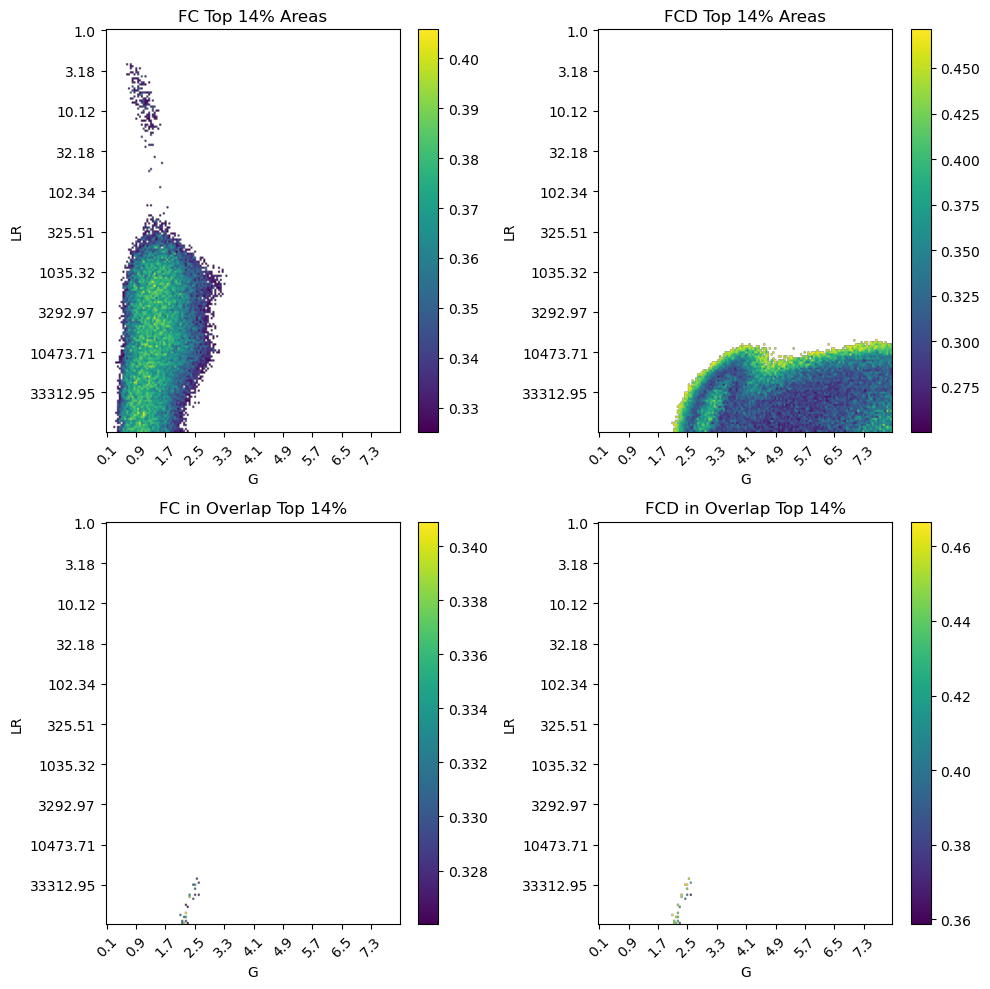

In [25]:

# Create visualization showing FC top 5%, FCD top 5%, and their overlap
plt.figure(figsize=(10, 10))
overlap_mask = hdmf_overlap_results[14]['overlap_mask']
fc_mask = hdmf_overlap_results[14]['fc_mask']
fcd_mask = hdmf_overlap_results[14]['fcd_mask']
thresh = 14
# Flip masks for plotting (to match the heatmap orientation)
fc_mask_flip = np.flipud(fc_mask)
fcd_mask_flip = np.flipud(fcd_mask)
overlap_mask_flip = np.flipud(overlap_mask)

# Create a mask of the HDMF_results_FC where only the overlapping points are shown, others are NaN
fc_values = np.where(fc_mask, HDMF_results_FC, np.nan)    
fc_values_flip = np.flipud(fc_values)
fcd_values = np.where(fcd_mask, HDMF_results_FCD, np.nan)    
fcd_values_flip = np.flipud(fcd_values)


# Plot 1: FC top 5%
plt.subplot(2, 2, 1)
plt.imshow(fc_values_flip, aspect='auto')
plt.colorbar()
plt.title(f'FC Top {thresh}% Areas')
plt.xlabel('G')
plt.ylabel('LR')
plt.xticks(ticks=np.arange(0, len(g_values), max(1, len(g_values)//10)), 
           labels=np.round(g_values[np.arange(0, len(g_values), max(1, len(g_values)//10))], 2), 
           rotation=45)
plt.yticks(ticks=np.arange(0, len(lr_values), max(1, len(lr_values)//10)), 
           labels=np.round(lr_values[np.arange(0, len(lr_values), max(1, len(lr_values)//10))], 2))

# Plot 2: FCD top 5%
plt.subplot(2, 2, 2)
plt.imshow(fcd_values_flip, aspect='auto')
plt.colorbar()
plt.title(f'FCD Top {thresh}% Areas')
plt.xlabel('G')
plt.ylabel('LR')
plt.xticks(ticks=np.arange(0, len(g_values), max(1, len(g_values)//10)), 
           labels=np.round(g_values[np.arange(0, len(g_values), max(1, len(g_values)//10))], 2), 
           rotation=45)
plt.yticks(ticks=np.arange(0, len(lr_values), max(1, len(lr_values)//10)), 
           labels=np.round(lr_values[np.arange(0, len(lr_values), max(1, len(lr_values)//10))], 2))

# Define tick positions
xt = np.arange(0, len(g_values), max(1, len(g_values)//10))
yt = np.arange(0, len(lr_values), max(1, len(lr_values)//10))

# Plot 3: FC values in the overlap area
plt.subplot(2, 2, 3)
fc_overlap = np.where(overlap_mask, HDMF_results_FC, np.nan)
fc_overlap_flip = np.flipud(fc_overlap)
plt.imshow(fc_overlap_flip, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title(f'FC in Overlap Top {thresh}%')
plt.xlabel('G')
plt.ylabel('LR')
plt.xticks(xt, np.round(g_values[xt], 2), rotation=45)
plt.yticks(yt, np.round(lr_values[yt], 2))

# Plot 4: FCD values in the overlap area
plt.subplot(2, 2, 4)
fcd_overlap = np.where(overlap_mask, HDMF_results_FCD, np.nan)
fcd_overlap_flip = np.flipud(fcd_overlap)
plt.imshow(fcd_overlap_flip, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title(f'FCD in Overlap Top {thresh}%')
plt.xlabel('G')
plt.ylabel('LR')
plt.xticks(xt, np.round(g_values[xt], 2), rotation=45)
plt.yticks(yt, np.round(lr_values[yt], 2))

plt.tight_layout()
plt.show()

# Selected repeated simulations

In [3]:
exp_dmf_fc = ExperimentManager(project_root=project_root, experiment_id="DMF_Top13%_Overlap", results_dir="/network/iss/cohen/data/Ivan/fastHDMF")
res_fc_dmf = exp_dmf_fc.load_experiment_results()

2025-12-12 15:52:39,799 - hdmf_experiment_DMF_Top13%_Overlap - INFO - Experiment 'DMF_Top13%_Overlap' initialized
2025-12-12 15:52:39,801 - hdmf_experiment_DMF_Top13%_Overlap - INFO - Config: Running 20 parameter combinations from DMF top 15% overlap
2025-12-12 15:52:39,802 - hdmf_experiment_DMF_Top13%_Overlap - INFO - Results will be saved to: /network/iss/cohen/data/Ivan/fastHDMF/DMF_Top13%_Overlap
2025-12-12 15:52:39,821 - hdmf_experiment_DMF_Top13%_Overlap - INFO - Loaded SC matrices for 1 patients from Averaged_SCs/aal with config threshold 0
2025-12-12 15:52:39,827 - hdmf_experiment_DMF_Top13%_Overlap - INFO - Searching for config file: DMF_Top13%_Overlap.yaml
2025-12-12 15:52:39,828 - hdmf_experiment_DMF_Top13%_Overlap - INFO - Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
2025-12-12 15:52:39,841 - hdmf_experiment_DMF_Top13%_Overlap - INFO - DMF_Top13%_Overlap
2025-12-12 15:52:39,842 - hdmf_experiment_DMF_Top13%_Overlap - INFO - Found config matches: [

INFO: Searching for config file: DMF_Top13%_Overlap.yaml
INFO: Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
INFO: DMF_Top13%_Overlap
INFO: Found config matches: [PosixPath('/network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/DMF_Top13%_Overlap.yaml')]
INFO: Loaded config from: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/DMF_Top13%_Overlap.yaml
Creating IPP list from SC matrices in: Averaged_SCs/aal
Found 1 IPPs from SC matrices


In [4]:
from joblib import Parallel, delayed
from numpy.random import default_rng
from scipy.stats import pearsonr, ks_2samp
import os

n_reps = 100
sample_size = 13
base_seed = 20241014

emp_fc = np.load(exp_dmf_fc.data_dir / "COMA_CNT_Empirical_FC.npy")
emp_fcd = np.load(exp_dmf_fc.data_dir / "COMA_CNT_Empirical_FCD.npy")
grid_size, nreps = res_fc_dmf['full_results']['observables']['fc_bold'].shape[:2]
nregions = res_fc_dmf['full_results']['observables']['fc_bold'][0,0].shape[0]
nwins = res_fc_dmf['full_results']['observables']['fcd_bold'][0,0].shape[1]
grid_size_fcd, nreps_fcd = res_fc_dmf['full_results']['observables']['fcd_bold'].shape[:2]
DMF_FC_repeats = np.stack(np.squeeze(res_fc_dmf["full_results"]["observables"]["fc_bold"]).flatten()).reshape((grid_size, nreps, nregions,nregions))
DMF_FCD_repeats = np.stack(np.squeeze(res_fc_dmf["full_results"]["observables"]["fcd_bold"]).flatten()).reshape((grid_size_fcd, nreps_fcd, nwins,nwins))

def bootstrap_grid(fc_repeats, fcd_repeats, emp_fc, emp_fcd, *, n_reps=100, sample_size=13,
                   n_jobs=None, prefer="threads", base_seed=None):
    n_grid = fc_repeats.shape[0]
    n_jobs = n_jobs or min(os.cpu_count() or 1, n_grid)
    triu_fc = np.triu_indices(fc_repeats.shape[-1], 1)
    triu_fcd = np.triu_indices(fcd_repeats.shape[-1], 1)
    emp_fc_triu = emp_fc[triu_fc].astype(np.float32, copy=False)
    emp_fcd_flat = emp_fcd.ravel().astype(np.float32, copy=False)

    seeds = default_rng(base_seed).integers(0, np.iinfo(np.uint32).max, size=n_grid, dtype=np.uint32)

    def _boot_single(i, seed):
        rng = default_rng(seed)
        sim_fcs = fc_repeats[i]
        sim_fcds = fcd_repeats[i]
        fc_out = np.empty(n_reps, dtype=np.float32)
        fcd_out = np.empty(n_reps, dtype=np.float32)
        for rep in range(n_reps):
            idx = rng.choice(sim_fcs.shape[0], sample_size, replace=False)
            fc_mean = sim_fcs[idx].mean(axis=0)
            fc_out[rep] = pearsonr(fc_mean[triu_fc], emp_fc_triu)[0]
            fcd_block = sim_fcds[idx][:, triu_fcd[0], triu_fcd[1]].reshape(-1)
            fcd_out[rep] = ks_2samp(fcd_block, emp_fcd_flat)[0]
        return fc_out, fcd_out

    results = Parallel(n_jobs=n_jobs, prefer=prefer, batch_size=1)(
        delayed(_boot_single)(i, seed) for i, seed in enumerate(seeds)
    )

    fc_res = np.vstack([r[0] for r in results])
    fcd_res = np.vstack([r[1] for r in results])
    return fc_res, fcd_res

In [6]:


n_jobs = min(os.cpu_count() or 1, DMF_FC_repeats.shape[0], 32)
DMF_FC_repeats_results, DMF_FCD_repeats_results = bootstrap_grid(
    DMF_FC_repeats,
    DMF_FCD_repeats,
    emp_fc,
    emp_fcd,
    n_reps=n_reps,
    sample_size=sample_size,
    n_jobs=n_jobs,
    base_seed=base_seed,
 )

DMF_FC_mean_results = DMF_FC_repeats_results.mean(axis=1)
DMF_FCD_mean_results = DMF_FCD_repeats_results.mean(axis=1)

# Save the results to .npy files
np.save(exp_dmf_fc.results_dir / "DMF_FC_Bootstrap_Results.npy", DMF_FC_mean_results)
np.save(exp_dmf_fc.results_dir / "DMF_FCD_Bootstrap_Results.npy", DMF_FCD_mean_results)

In [5]:
exp_hdmf_fc = ExperimentManager(project_root=project_root, experiment_id="HDMF_Top14%_Overlap", results_dir="/network/iss/cohen/data/Ivan/fastHDMF")
res_fc_hdmf = exp_hdmf_fc.load_experiment_results()

2025-12-12 15:52:59,595 - hdmf_experiment_HDMF_Top14%_Overlap - INFO - Experiment 'HDMF_Top14%_Overlap' initialized
2025-12-12 15:52:59,596 - hdmf_experiment_HDMF_Top14%_Overlap - INFO - Config: Running 21 parameter combinations from HDMF top 15% overlap
2025-12-12 15:52:59,597 - hdmf_experiment_HDMF_Top14%_Overlap - INFO - Results will be saved to: /network/iss/cohen/data/Ivan/fastHDMF/HDMF_Top14%_Overlap
2025-12-12 15:52:59,613 - hdmf_experiment_HDMF_Top14%_Overlap - INFO - Loaded SC matrices for 1 patients from Averaged_SCs/aal with config threshold 0
2025-12-12 15:52:59,617 - hdmf_experiment_HDMF_Top14%_Overlap - INFO - Searching for config file: HDMF_Top14%_Overlap.yaml
2025-12-12 15:52:59,618 - hdmf_experiment_HDMF_Top14%_Overlap - INFO - Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
2025-12-12 15:52:59,629 - hdmf_experiment_HDMF_Top14%_Overlap - INFO - HDMF_Top14%_Overlap
2025-12-12 15:52:59,631 - hdmf_experiment_HDMF_Top14%_Overlap - INFO - Found conf

INFO: Searching for config file: HDMF_Top14%_Overlap.yaml
INFO: Configs directory: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs
INFO: HDMF_Top14%_Overlap
INFO: Found config matches: [PosixPath('/network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/HDMF_Top14%_Overlap.yaml')]
INFO: Loaded config from: /network/iss/home/ivan.mindlin/Repos/fastHDMF/configs/experiments/HDMF_Top14%_Overlap.yaml
Creating IPP list from SC matrices in: Averaged_SCs/aal
Found 1 IPPs from SC matrices


In [7]:
n_reps = 100
sample_size = 13
#emp_fc = np.load(exp_hdmf_fc.data_dir / "COMA_CNT_Empirical_FC.npy")
#emp_fcd = np.load(exp_hdmf_fc.data_dir / "COMA_CNT_Empirical_FCD.npy")
grid_size, nreps = res_fc_hdmf['full_results']['observables']['fc_bold'].shape[:2]
nregions = res_fc_hdmf['full_results']['observables']['fc_bold'][0,0].shape[0]
nwins = res_fc_hdmf['full_results']['observables']['fcd_bold'][0,0].shape[1]
grid_size_fcd, nreps_fcd = res_fc_hdmf['full_results']['observables']['fcd_bold'].shape[:2]
HDMF_FC_repeats = np.stack(np.squeeze(res_fc_hdmf["full_results"]["observables"]["fc_bold"]).flatten()).reshape((grid_size, nreps, nregions,nregions))
grid_size, nreps = res_fc_hdmf['full_results']['observables']['fc_bold'].shape[:2]
HDMF_FCD_repeats = np.stack(np.squeeze(res_fc_hdmf["full_results"]["observables"]["fcd_bold"]).flatten()).reshape((grid_size, nreps, nwins,nwins))

n_jobs = min(os.cpu_count() or 1, HDMF_FC_repeats.shape[0], 32)
HDMF_FC_repeats_results, HDMF_FCD_repeats_results = bootstrap_grid(
    HDMF_FC_repeats,
    HDMF_FCD_repeats,
    emp_fc,
    emp_fcd,
    n_reps=n_reps,
    sample_size=sample_size,
    n_jobs=n_jobs,
    base_seed=base_seed + 1,
 )

HDMF_FC_mean_results = HDMF_FC_repeats_results.mean(axis=1)
HDMF_FCD_mean_results = HDMF_FCD_repeats_results.mean(axis=1)

# save the results in .npy files
np.save(exp_hdmf_fc.results_dir / "results" / "HDMF_FC_Bootstrap_Results.npy", HDMF_FC_mean_results)
np.save(exp_hdmf_fc.results_dir / "results" / "HDMF_FCD_Bootstrap_Results.npy", HDMF_FCD_mean_results)

In [8]:
import numpy as np
from scipy.stats import mannwhitneyu
def compare_best_points(gof_A, gof_B, lower_is_better=True):
    """Compare best grid point of each model using Cohen’s d."""
    # find best‐point indices
    means_A = gof_A.mean(axis=1)
    means_B = gof_B.mean(axis=1)
    bestA_idx = np.argmin(means_A) if lower_is_better else np.argmax(means_A)
    bestB_idx = np.argmin(means_B) if lower_is_better else np.argmax(means_B)

    # extract the repeat values at those best points
    valsA = gof_A[bestA_idx]
    valsB = gof_B[bestB_idx]

    # compute means
    meanA, meanB = valsA.mean(), valsB.mean()
    # sample sizes
    nA, nB = valsA.size, valsB.size
    # unbiased variances
    varA, varB = valsA.var(ddof=1), valsB.var(ddof=1)
    # pooled standard deviation
    pooled_sd = np.sqrt(((nA - 1)*varA + (nB - 1)*varB) / (nA + nB - 2))
    # Cohen's d
    cohen_d = (meanA - meanB) / pooled_sd

    return {
        'bestA_idx': bestA_idx,
        'bestB_idx': bestB_idx,
        'meanA': meanA,
        'meanB': meanB,
        'cohen_d': cohen_d,
        'better': 'A' if (meanA < meanB if lower_is_better else meanA > meanB) else 'B'
    }


In [9]:
res_FC = compare_best_points(DMF_FC_repeats_results, HDMF_FC_repeats_results, lower_is_better=False)
res_FCD = compare_best_points(DMF_FCD_repeats_results, HDMF_FCD_repeats_results)

print("FC:", res_FC)
print("FCD:", res_FCD)

np.save(exp_dmf_fc.experiment_dir / "DMF_FC_Bootstrap_Results.npy", DMF_FC_repeats_results)
np.save(exp_dmf_fc.experiment_dir / "DMF_FCD_Bootstrap_Results.npy", DMF_FCD_repeats_results)
np.save(exp_hdmf_fc.experiment_dir / "HDMF_FC_Bootstrap_Results.npy", HDMF_FC_mean_results)
np.save(exp_hdmf_fc.experiment_dir / "HDMF_FCD_Bootstrap_Results.npy", HDMF_FCD_mean_results)

# Save the index of the best grid point for each model and metric
np.save(exp_dmf_fc.experiment_dir / "DMF_FC_Best_Point_Index.npy", res_FC['bestA_idx'])
np.save(exp_dmf_fc.experiment_dir / "DMF_FCD_Best_Point_Index.npy", res_FCD['bestA_idx'])
np.save(exp_hdmf_fc.experiment_dir / "HDMF_FC_Best_Point_Index.npy", res_FC['bestB_idx'])
np.save(exp_hdmf_fc.experiment_dir / "HDMF_FCD_Best_Point_Index.npy", res_FCD['bestB_idx'])


FC: {'bestA_idx': 6, 'bestB_idx': 20, 'meanA': 0.36388066, 'meanB': 0.33208504, 'cohen_d': 3.045614418039599, 'better': 'A'}
FCD: {'bestA_idx': 4, 'bestB_idx': 15, 'meanA': 0.11785023, 'meanB': 0.12374678, 'cohen_d': -0.8487322408886779, 'better': 'A'}


In [10]:
print(f"DMF FC Best Point: {exp_dmf_fc.current_config['tasks_list'][res_FC['bestA_idx']]}")
print(f"HDMF FC Best Point: {exp_hdmf_fc.current_config['tasks_list'][res_FC['bestB_idx']]}")


DMF FC Best Point: {'G': 2.0500000000000007, 'alpha': 0.7214070351758795}
HDMF FC Best Point: {'G': 2.5500000000000007, 'lrj': 3.5707859649004634}


In [11]:
print(f"DMF FCD Best Point: {exp_dmf_fc.current_config['tasks_list'][res_FCD['bestA_idx']]}")
print(f"HDMF FCD Best Point: {exp_hdmf_fc.current_config['tasks_list'][res_FCD['bestB_idx']]}")

DMF FCD Best Point: {'G': 1.9500000000000006, 'alpha': 0.7015075376884422}
HDMF FCD Best Point: {'G': 2.600000000000001, 'lrj': 2.2478058335487257}


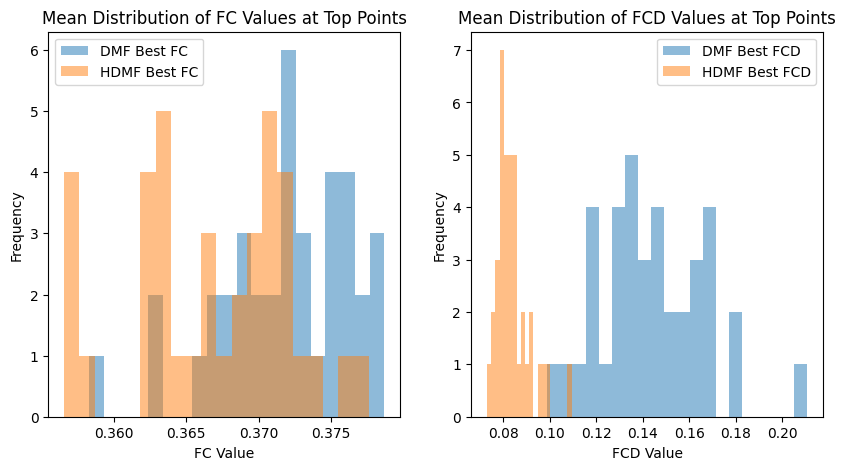

In [133]:
# Plot the distribution of FC values at the best points
#best_DMF_FC_vals = DMF_FC_repeats_results[res_FC['bestA_idx']]

#best_HDMF_FC_vals = HDMF_FC_repeats_results[res_FC['bestB_idx']]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(DMF_FC_mean_results, bins=20, alpha=0.5, label='DMF Best FC')
plt.hist(HDMF_FC_mean_results, bins=20, alpha=0.5, label='HDMF Best FC')
plt.title('Mean Distribution of FC Values at Top Points')
plt.xlabel('FC Value')
plt.ylabel('Frequency')
plt.legend()
# Plot the distribution of FCD values at the best points
#best_DMF_FCD_vals = DMF_FCD_repeats_results[res_FCD['bestA_idx']]
#best_HDMF_FCD_vals = HDMF_FCD_repeats_results[res_FCD['bestB_idx']]

plt.subplot(1, 2, 2)
plt.hist(DMF_FCD_mean_results, bins=20, alpha=0.5, label='DMF Best FCD')
plt.hist(HDMF_FCD_mean_results, bins=20, alpha=0.5, label='HDMF Best FCD')
plt.title('Mean Distribution of FCD Values at Top Points')
plt.xlabel('FCD Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()